# Google Analytics Customer Lifetime Value Capstone

This project’s aim is to analyze Google Merchandise Store data, specifically the customer dataset, in order to run predictions for revenue per customer. This is a form of a customer lifetime value model. Essentially, this project’s aim is to use machine learning, specifically regression, in order to predict how much a customer may spend in the store given customer attributes and segments.

**Question**

We will use customer transaction data as an input to predict total customer spend within a certain window via clustering and regression techniques. This helps answer the question: _Can we accurately predict how much a customer will spend, thus allowing marketers to target high spending customers with more advertisements?_

## Exploratory Data Analysis

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import pickle
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [3]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [52]:
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train.dtypes

channelGrouping                object
date                            int64
fullVisitorId                  object
visitId                         int64
visitNumber                     int64
visitStartTime                  int64
device.browser                 object
device.deviceCategory          object
device.isMobile                  bool
device.operatingSystem         object
geoNetwork.city                object
geoNetwork.continent           object
geoNetwork.country             object
geoNetwork.metro               object
geoNetwork.networkDomain       object
geoNetwork.region              object
geoNetwork.subContinent        object
totals.bounces                float64
totals.hits                     int64
totals.newVisits              float64
totals.pageviews              float64
totals.transactionRevenue     float64
trafficSource.adContent        object
trafficSource.campaign         object
trafficSource.isTrueDirect     object
trafficSource.keyword          object
trafficSourc

In [6]:
train.sample(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
190321,Social,20160901,5598915828525099033,1472722051,1,1472722051,Chrome,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,NaN,referral,/yt/about/tr/,youtube.com
255822,Organic Search,20160813,2254679158116429824,1471108773,1,1471108773,Safari,mobile,True,iOS,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
324159,Organic Search,20161009,5784541772477326661,1476032054,8,1476032054,Chrome,desktop,False,Windows,...,NaN,1.0,NaN,NaN,(not set),True,(not provided),organic,NaN,google
153446,Social,20161026,315634001685820280,1477546256,1,1477546256,Chrome,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,NaN,referral,/yt/about/vi/,youtube.com
252260,Direct,20170426,826122121462058835,1493214467,2,1493214467,Chrome,mobile,True,Android,...,NaN,1.0,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)


In [7]:
train.shape

(903653, 29)

In [8]:
train.describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,450630.0,903653.000000,703060.0,903553.000000,1.151500e+04
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,1.0,4.596538,1.0,3.849764,1.337448e+08
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,0.0,9.641437,0.0,7.025274,4.482852e+08
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,1.0,1.000000,1.0,1.000000,1.000000e+04
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,1.0,1.000000,1.0,1.000000,2.493000e+07
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,1.0,2.000000,1.0,1.000000,4.945000e+07
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,1.0,4.000000,1.0,4.000000,1.076550e+08
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.0,500.000000,1.0,469.000000,2.312950e+10


In [9]:
train['trafficSource.medium'].unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

#### Outcome: `totals.transactionRevenue`

We are trying to predict the natural log of transaction revenue by users, so we first apply the natural log and then sort the values from smallest to largest.

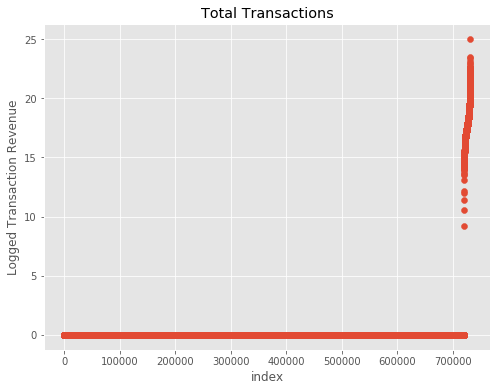

In [10]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype('float')
txns_by_users = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(txns_by_users.shape[0]), np.sort(np.log1p(txns_by_users["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('Logged Transaction Revenue', fontsize=12)
plt.title('Total Transactions')
plt.show()

The Kaggle competition that I am using started off with saying that 80% of the transactions come from 20% of the users, and this visualization seems to be in line with that logic. Let's take a look at the top users who spend the most.

In [11]:
txns_by_users.sort_values('totals.transactionRevenue', ascending = False).head(5)

,fullVisitorId,totals.transactionRevenue
182593,1957458976293878100,7.591669e+10
392626,5632276788326171571,1.602375e+10
610261,9417857471295131045,1.517012e+10
326192,4471415710206918415,1.121110e+10
355498,4984366501121503466,9.513900e+09


In [12]:
train.loc[train.fullVisitorId.isin(txns_by_users.sort_values('totals.transactionRevenue', ascending = False).head(5)['fullVisitorId'])].loc[~pd.isnull(train['totals.transactionRevenue'])].head(10)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
22500,Direct,20161110,4984366501121503466,1478792651,6,1478792651,Chrome,desktop,False,Chrome OS,...,NaN,32.0,5.382000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
89918,Direct,20161130,4984366501121503466,1480527609,8,1480527609,Chrome,desktop,False,Chrome OS,...,NaN,30.0,6.970000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
126655,Direct,20161018,4984366501121503466,1476808875,2,1476808875,Chrome,desktop,False,Chrome OS,...,NaN,22.0,2.740000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
142416,Direct,20170410,4984366501121503466,1491864249,22,1491864249,Chrome,desktop,False,Chrome OS,...,NaN,43.0,4.597000e+07,NaN,(not set),True,NaN,(none),NaN,(direct)
249668,Direct,20170105,4984366501121503466,1483653271,14,1483653271,Chrome,desktop,False,Chrome OS,...,NaN,39.0,1.633420e+09,NaN,(not set),True,NaN,(none),NaN,(direct)
275470,Direct,20170620,4984366501121503466,1497998174,24,1497998174,Chrome,desktop,False,Chrome OS,...,NaN,26.0,7.310800e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
287213,Direct,20170728,9417857471295131045,1501255344,19,1501255344,Chrome,desktop,False,Windows,...,NaN,51.0,6.855200e+08,NaN,(not set),True,NaN,(none),NaN,(direct)
339913,Direct,20170721,9417857471295131045,1500657634,10,1500657634,Chrome,desktop,False,Windows,...,NaN,76.0,1.064080e+09,NaN,(not set),True,NaN,(none),NaN,(direct)
348275,Display,20170601,1957458976293878100,1496342143,295,1496342143,Firefox,desktop,False,Windows,...,NaN,24.0,2.344000e+08,NaN,(not set),True,NaN,cpm,NaN,dfa
354592,Direct,20161027,4984366501121503466,1477584959,3,1477584959,Chrome,desktop,False,Chrome OS,...,NaN,43.0,2.904000e+08,NaN,(not set),True,NaN,(none),NaN,(direct)


From the sample above, it looks like top users use desktops to make transactions; however, their operating systems are quite diverse between Windows, Chrome, and Mac. There is still some hesitation that these could be affiliate companies or internal employees buying large amount of items for their teams, but this is something worth exploring.

In [13]:
not_null_rev = train.loc[~pd.isna(train['totals.transactionRevenue'])]['fullVisitorId'].count()
no_spend_customers = txns_by_users.loc[txns_by_users['totals.transactionRevenue'] > 0]['fullVisitorId'].count()
not_null_rev/train.shape[0], no_spend_customers/txns_by_users.shape[0]

(0.0127427231470487, 0.013976902495279737)

We note from above that out of all visitors visiting the Google Store, only 1.4% of visitors are revenue generating customers. 

*Note that this data begins from August 01 2016 and ends on August 01 2017

#### Device Category, Operating System, and Browser

In [14]:
train.groupby('device.deviceCategory')['totals.transactionRevenue']

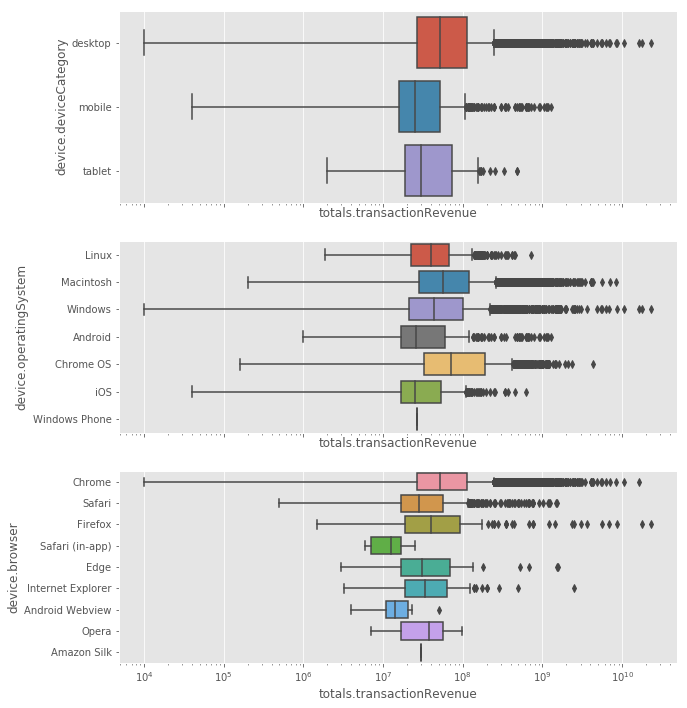

In [15]:
f, axes = plt.subplots(3, figsize=(10, 12), sharex=True)
for i, k in enumerate(['device.deviceCategory', 'device.operatingSystem', 'device.browser']):
    sns.boxplot(y=k, x="totals.transactionRevenue", data=train.loc[~pd.isnull(train['totals.transactionRevenue'])], dodge=False, ax=axes[i])
    axes[i].set_xscale('log')

Above we see boxplots for device types, operating systems, and browsers of non-null transaction revenues. We note a few observations:
- The majority of customers use Desktops for purchases.
    - Surprisingly tablets are the second highest usage for purchases, followed by mobile phones.
- Chrome OS has the highest median spend at the Google store, this plays into my theory that it could be Google employees who are purchasing Google products.
- Unsurprisingly, Chrome had the highest median revenue of the web browsers; however, Firefox was a surprise in second place.

#### Country Exploration

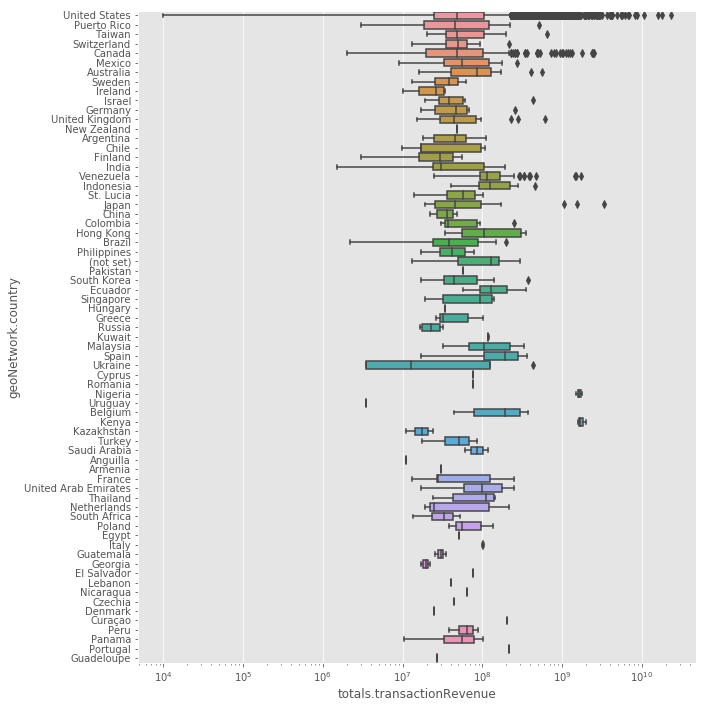

In [16]:
f, axes = plt.subplots(figsize=(10, 12), sharex=True)

sns.boxplot(y='geoNetwork.country', x="totals.transactionRevenue", data=train.loc[~pd.isnull(train['totals.transactionRevenue'])], dodge=False)
axes.set_xscale('log')

Country has some interesting observations. US tops in revenue as expected; however, Australia has a higher median spend than the US which is surprising. Additionally, Canada shows similar variance as the US, which was also surprising to me. This seems like an important feature to use in the model.

#### Channel Grouping

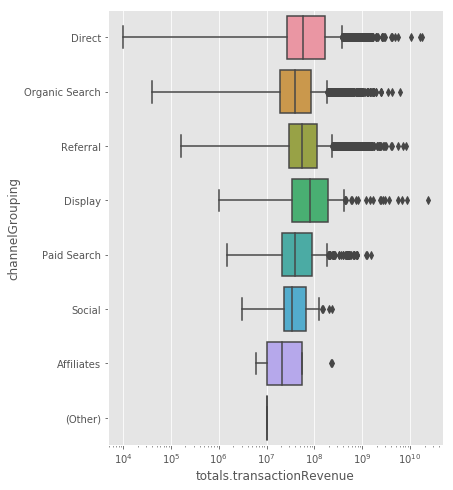

In [17]:
f, axes = plt.subplots(figsize=(6, 8), sharex=True)

sns.boxplot(y='channelGrouping', x="totals.transactionRevenue", data=train.loc[~pd.isnull(train['totals.transactionRevenue'])], dodge=False)
axes.set_xscale('log')

Channel grouping also shows some variance with Display ads having the highest median (which is also very interesting). Definitely something to consider as a potential feature in the model.

#### Potential Indirect Outcome: Page Views

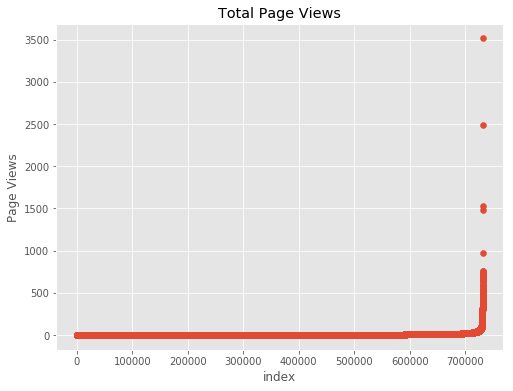

In [18]:
train['totals.pageviews'] = train['totals.pageviews'].astype('float')
pg_by_users = train.groupby("fullVisitorId")["totals.pageviews"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(pg_by_users.shape[0]), np.sort(pg_by_users["totals.pageviews"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Page Views', fontsize=12)
plt.title('Total Page Views')
plt.show()

We note the similarities between page views and total revenue, thus we can use page views as an indirect outcome because ultimately users need to view a page before purchasing a product. This allows us to switch our cluster methodology from: Recency, Frequency, and Monetary to Recency, Frequency, and Views.

## Feature Engineering

#### Recency Cluster

In [53]:
non_zero_txn = train.loc[pd.notnull(train['totals.pageviews'])]

In [54]:
tx_user = pd.DataFrame(train['fullVisitorId'].unique())
tx_user.columns = ['fullVisitorId']

In [55]:
train['date_format'] = pd.to_datetime(train['date'], format="%Y%m%d")
tx_max_purchase = train.groupby('fullVisitorId').date_format.max().reset_index()
tx_max_purchase.columns = ['fullVisitorId','date_format']

tx_max_purchase['recency'] = (tx_max_purchase['date_format'].max() - tx_max_purchase['date_format']).dt.days

tx_user = pd.merge(tx_user, tx_max_purchase[['fullVisitorId','recency']], on='fullVisitorId')

In [56]:
tx_max_purchase.count()

fullVisitorId    731421
date_format      731421
recency          731421
dtype: int64

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


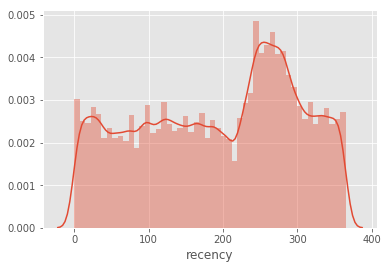

In [57]:
sns.distplot(tx_user['recency'])

In [58]:
tx_user.describe()

,recency
count,731421.000000
mean,192.779170
std,104.437801
min,0.000000
25%,103.000000
50%,207.000000
75%,279.000000
max,365.000000


We see that the median recency is 207 days, while the mean is close -- 192. We may be able to infer from the graph above that the median purchases were made between 279 and 201 days prior to August 1 2017, which is around from October 2016 to January 2017, which makes sense because this is around the holiday season.

In [59]:
datetime(2017,8,1) - timedelta(279)

datetime.datetime(2016, 10, 26, 0, 0)

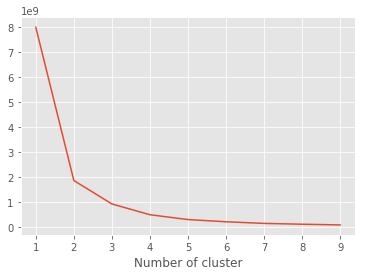

{1: 7977783913.472026,
 2: 1867537513.8041782,
 3: 933583755.1881189,
 4: 503591465.3749925,
 5: 311324888.56120056,
 6: 222849392.30482557,
 7: 158013209.27841213,
 8: 125412557.99410607,
 9: 97666929.57604559}

In [60]:
def plot_kmeans_inertia(feature):
    tmp = tx_user[[feature]]
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tmp)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    return sse
    
plot_kmeans_inertia('recency')

We see from the chart above that we can choose either 3 or 4 clusters. We will choose 4 just to have more features in our model. 

In [61]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(tx_user[['recency']])

## Save model to use for test as well
filename = '../feature_models/kmeans_recency.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [62]:
# def engineer_features(user_df, df, model_file, col_name):
#     mod1 = pickle.load(open(model_file, 'rb'))
#     user_df[col_name+"_cluster"] = mod1.predict(user_df[col_name])
#     df = pd.merge(df, user_df[['fullVisitorId']])   

In [63]:
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
tx_user['recency_cluster'] = mod1.predict(tx_user[['recency']])

In [64]:
tx_user.groupby(['recency_cluster']).agg({'recency' : ['min', 'max', 'mean']})

recency                 
                    min  max        mean
recency_cluster                         
0                   196  284  246.868415
1                     0   94   45.135431
2                    95  195  144.323179
3                   285  365  322.797862

#### Frequency Cluster

In [65]:
tx_frequency = non_zero_txn.groupby('fullVisitorId').visitId.count().reset_index()

In [66]:
tx_frequency.columns = ['fullVisitorId','frequency']

In [67]:
tx_user = pd.merge(tx_user, tx_frequency, on='fullVisitorId')

In [68]:
tx_user.describe()

,recency,recency_cluster,frequency
count,731407.000000,731407.000000,731407.000000
mean,192.778066,1.397371,1.235363
std,104.437826,1.136006,1.272507
min,0.000000,0.000000,1.000000
25%,103.000000,0.000000,1.000000
50%,207.000000,1.000000,1.000000
75%,279.000000,2.000000,1.000000
max,365.000000,3.000000,252.000000


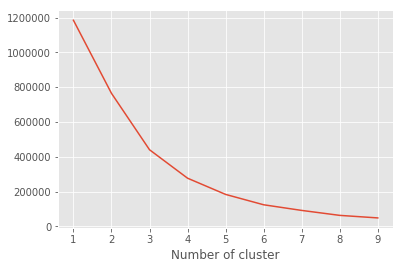

{1: 1184347.2353040099,
 2: 764615.5861093879,
 3: 440347.3759658393,
 4: 276898.63847980666,
 5: 183702.3566994792,
 6: 124179.72863825502,
 7: 91752.87594459842,
 8: 63287.06492928522,
 9: 48672.80575292426}

In [69]:
plot_kmeans_inertia('frequency')

Our intertia graph above doesn't have a concrete elbow; however, I will select 5 clusters to have more variance in the feature space.

In [70]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(tx_user[['frequency']])

## Save model to use for test as well
filename = '../feature_models/kmeans_frequency.sav'
pickle.dump(kmeans, open(filename, 'wb'))
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
tx_user['frequency_cluster'] = mod1.predict(tx_user[['frequency']])

In [71]:
tx_user.groupby(['frequency_cluster']).agg({'frequency' : ['min', 'max']})

frequency     
                        min  max
frequency_cluster               
0                         1    1
1                        16   68
2                         5   15
3                         2    4
4                        75  252

#### Page View Cluster

In [72]:
tx_pv = non_zero_txn.groupby('fullVisitorId').agg({'totals.pageviews' : 'sum'}).reset_index()
tx_pv.columns = ['fullVisitorId','pg_views']
tx_user = pd.merge(tx_user, tx_pv, on='fullVisitorId')

In [73]:
tx_user.describe()

,recency,recency_cluster,frequency,frequency_cluster,pg_views
count,731407.000000,731407.000000,731407.000000,731407.000000,731407.000000
mean,192.778066,1.397371,1.235363,0.353845,4.755855
std,104.437826,1.136006,1.272507,0.955360,13.004957
min,0.000000,0.000000,1.000000,0.000000,1.000000
25%,103.000000,0.000000,1.000000,0.000000,1.000000
50%,207.000000,1.000000,1.000000,0.000000,2.000000
75%,279.000000,2.000000,1.000000,0.000000,4.000000
max,365.000000,3.000000,252.000000,4.000000,3513.000000


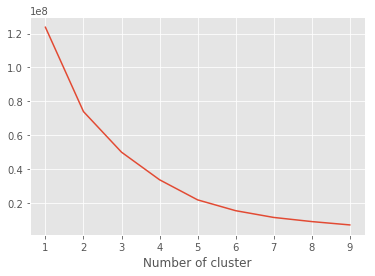

{1: 123701900.35987896,
 2: 73935481.96393521,
 3: 49975382.37333333,
 4: 33692989.18748228,
 5: 21832795.808658056,
 6: 15448358.498059532,
 7: 11462811.840571232,
 8: 9019850.35626106,
 9: 7047820.691085498}

In [74]:
plot_kmeans_inertia('pg_views')

In [75]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(tx_user[['pg_views']])

## Save model to use for test as well
filename = '../feature_models/kmeans_pg_views.sav'
pickle.dump(kmeans, open(filename, 'wb'))
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
tx_user['pg_views_cluster'] = mod1.predict(tx_user[['pg_views']])

In [76]:
tx_user.groupby(['pg_views_cluster']).agg({'pg_views' : ['min', 'max']})

pg_views        
                      min     max
pg_views_cluster                 
0                     1.0    22.0
1                    23.0   129.0
2                  1477.0  3513.0
3                   130.0   969.0

#### Country Cluster

In [77]:
df_country = train.loc[pd.notnull(train['totals.pageviews'])].groupby(['geoNetwork.country']).agg({'totals.pageviews' : ['mean', 'median', 'sum', 'std']}).reset_index()
df_country.columns = ['geoNetwork.country', 'mean', 'median', 'sum', 'std']
df_country.fillna(0, inplace=True)
mm = MinMaxScaler()
for col in df_country.columns[1:]:
    df_country[col + "_scl"] = mm.fit_transform(df_country[[col]])

In [78]:
df_country.head()

,geoNetwork.country,mean,median,sum,std,mean_scl,median_scl,sum_scl,std_scl
0,(not set),2.675989,1.0,3923.0,4.540985,0.119714,0.0,0.001930,0.153162
1,Afghanistan,2.052632,1.0,117.0,2.966606,0.075188,0.0,0.000057,0.100060
2,Albania,1.661792,1.0,909.0,1.719545,0.047271,0.0,0.000447,0.057998
3,Algeria,1.696837,1.0,3487.0,2.442935,0.049774,0.0,0.001716,0.082397
4,American Samoa,1.000000,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000


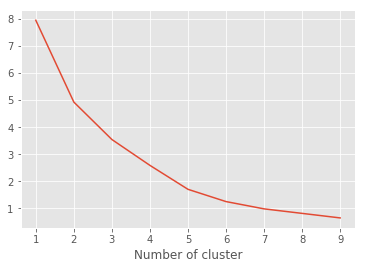

In [79]:
tmp = df_country[['mean_scl', 'median_scl', 'sum_scl', 'std_scl']]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tmp)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

From the chart above, it looks like the elbow can be anywhere from 4-6; however, for more variability, we will choose 6.

In [83]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit(df_country[['mean_scl', 'median_scl', 'sum_scl', 'std_scl']])
## Save model to use for test as well
filename = '../feature_models/kmeans_country.sav'
pickle.dump(kmeans, open(filename, 'wb'))
model_file = filename
mod1 = pickle.load(open(model_file, 'rb'))
df_country['country_cluster'] = mod1.predict(df_country[['mean_scl', 'median_scl', 'sum_scl', 'std_scl']])

In [94]:
df_country.loc[df_country.country_cluster == 4]

,geoNetwork.country,mean,median,sum,std,mean_scl,median_scl,sum_scl,std_scl,country_cluster
36,Canada,5.078517,2.0,131366.0,7.846749,0.291323,0.071429,0.064651,0.264662,4
49,Costa Rica,3.828520,2.0,2121.0,6.217096,0.202037,0.071429,0.001043,0.209696,4
61,El Salvador,4.905852,2.0,1928.0,8.484006,0.278989,0.071429,0.000948,0.286156,4
71,French Polynesia,3.950000,1.5,79.0,6.508901,0.210714,0.035714,0.000038,0.219538,4
83,Guatemala,4.800344,2.0,2789.0,7.908620,0.271453,0.071429,0.001372,0.266749,4
84,Guernsey,5.200000,2.0,130.0,7.979139,0.300000,0.071429,0.000063,0.269128,4
90,Hong Kong,3.638253,1.0,17158.0,7.413479,0.188447,0.000000,0.008444,0.250048,4
98,Isle of Man,5.666667,3.0,17.0,6.429101,0.333333,0.142857,0.000008,0.216846,4
110,Laos,3.701863,1.0,596.0,14.640630,0.192990,0.000000,0.000293,0.493812,4
128,Martinique,4.459016,1.0,272.0,9.484327,0.247073,0.000000,0.000133,0.319896,4


#### Apply Clusters to Test Data

In [95]:
non_zero_txn_tst = test.loc[pd.notnull(test['totals.pageviews'])]
tx_user_tst = pd.DataFrame(non_zero_txn_tst['fullVisitorId'].unique())
tx_user_tst.columns = ['fullVisitorId']
test['date_format'] = pd.to_datetime(test['date'], format="%Y%m%d")

# Recency
tx_max_purchase_tst = test.groupby('fullVisitorId').date_format.max().reset_index()
tx_max_purchase_tst.columns = ['fullVisitorId','date_format']
tx_max_purchase_tst['recency'] = (tx_max_purchase_tst['date_format'].max() - tx_max_purchase_tst['date_format']).dt.days
tx_user_tst = pd.merge(tx_user_tst, tx_max_purchase_tst[['fullVisitorId','recency']], on='fullVisitorId')
model_file = '../feature_models/kmeans_recency.sav'
mod1 = pickle.load(open(model_file, 'rb'))
tx_user_tst['recency_cluster'] = mod1.predict(tx_user_tst[['recency']])

# Frequency
tx_frequency_tst = non_zero_txn_tst.groupby('fullVisitorId').visitId.count().reset_index()
tx_frequency_tst.columns = ['fullVisitorId','frequency']
tx_user_tst = pd.merge(tx_user_tst, tx_frequency_tst, on='fullVisitorId')
model_file = '../feature_models/kmeans_frequency.sav'
mod1 = pickle.load(open(model_file, 'rb'))
tx_user_tst['frequency_cluster'] = mod1.predict(tx_user_tst[['frequency']])

# Page Views
tx_pv_tst = non_zero_txn_tst.groupby('fullVisitorId').agg({'totals.pageviews' : 'sum'}).reset_index()
tx_pv_tst.columns = ['fullVisitorId','pg_views']
tx_user_tst = pd.merge(tx_user_tst, tx_pv_tst, on='fullVisitorId')
model_file = '../feature_models/kmeans_pg_views.sav'
mod1 = pickle.load(open(model_file, 'rb'))
tx_user_tst['pg_views_cluster'] = mod1.predict(tx_user_tst[['pg_views']])

# Country

df_country_tst = test.loc[pd.notnull(test['totals.pageviews'])].groupby(['geoNetwork.country']).agg({'totals.pageviews' : ['mean', 'median', 'sum', 'std']}).reset_index()
df_country_tst.columns = ['geoNetwork.country', 'mean', 'median', 'sum', 'std']
df_country_tst.fillna(0, inplace=True)
mm = MinMaxScaler()
for col in df_country_tst.columns[1:]:
    df_country_tst[col + "_scl"] = mm.fit_transform(df_country_tst[[col]])
model_file = '../feature_models/kmeans_country.sav'
mod1 = pickle.load(open(model_file, 'rb'))
df_country_tst['country_cluster'] = mod1.predict(df_country_tst[['mean_scl', 'median_scl', 'sum_scl', 'std_scl']])

#### Join Clusters Back to Train and Test

In [96]:
def join_rfm_clusters(main_df, cluster_df, on_clause):
    out_df = pd.merge(main_df, cluster_df, on = on_clause)
    clus_cols = ['recency', 'frequency', 'pg_views']
    for clus in clus_cols:
        out_df.loc[pd.isnull(out_df[clus]),clus] = -1
        clus_cluster = clus + "_cluster"
        out_df.loc[pd.isnull(out_df[clus_cluster]),clus_cluster] = -1 
    return out_df

def join_country_clusters(main_df, cluster_df, on_clause):
    out_df = pd.merge(main_df, cluster_df, on = on_clause)
    out_df.loc[pd.isnull(out_df['country_cluster']),'country_cluster'] = -1 
    return out_df


In [97]:
train = join_rfm_clusters(train, tx_user, ['fullVisitorId'])
test = join_rfm_clusters(test, tx_user_tst, ['fullVisitorId'])

In [98]:
train = join_country_clusters(train, df_country, ['geoNetwork.country'])
test = join_country_clusters(test, df_country, ['geoNetwork.country'])

In [99]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'date_format', 'recency', 'recency_cluster',
       'frequency', 'frequency_cluster', 'pg_views', 'pg_views_cluster',
       'mean', 'median', 'sum', 'std', 'mean_scl', 'median_scl', 'sum_scl',
       'std_scl', 'country_cluster'],
      dtype='object')

In [100]:
train.shape, test.shape

((903639, 45), (804617, 44))

In [105]:
[var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]

['_11',
 '_12',
 '_24',
 '_30',
 '_34',
 '_37',
 '_39',
 '_42',
 '_44',
 '_47',
 '_58',
 '_6',
 '_64',
 '_68',
 '_71',
 '_73',
 '_76',
 '_78',
 '_8',
 '_81',
 '_82',
 '_84',
 '_85',
 '_86',
 '_87',
 '_88',
 '_89',
 '_90',
 '_91',
 '_92',
 '_93',
 '_94',
 'test',
 'train']

In [104]:
tx_frequency = None
tx_frequency_tst = None
tx_max_purchase = None
tx_max_purchase_tst = None
tx_pv = None
tx_pv_tst = None
tx_user = None
tx_user_tst = None
txns_by_users = None
non_zero_txn = None
non_zero_txn_tst = None
pg_by_users = None
df_country = None
df_country_tst = None
tmp = None

## Upload Data to S3

In [ ]:
# Country, Hits, channel Grouping, device category, device operating system, device browser, referral path, is true direct and then our clusters. 

In [109]:
feature_list = ['totals.transactionRevenue', 'country_cluster', 'totals.hits', 'channelGrouping', 'device.deviceCategory', 'device.operatingSystem', 'recency_cluster', 'frequency_cluster', 'pg_views_cluster']

In [112]:
train_in = train[feature_list]
for col in [x for x in feature_list if x.find('cluster') > -1 ]:
    train_in[col] = train_in[col].astype('str')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [113]:
train_in.dtypes

totals.transactionRevenue    float64
country_cluster               object
totals.hits                    int64
channelGrouping               object
device.deviceCategory         object
device.operatingSystem        object
recency_cluster               object
frequency_cluster             object
pg_views_cluster              object
dtype: object

In [114]:
train_in = pd.get_dummies(train_in, drop_first=True)

In [115]:
train, dev = train_test_split(train_in, test_size=0.20, random_state=42)

train = train.fillna(0)
dev = dev.fillna(0)

In [116]:
train.to_csv('../data/train_data.csv', index = False, header = False)
dev.to_csv('../data/dev_data.csv', index = False, header = False)

In [117]:
# should be the name of directory you created to save your features data
data_dir = '../data'

# set prefix, a descriptive name for a directory  
prefix = 'google_analytics'

# upload all data to S3
train_prefix = '{}/{}'.format(prefix, 'train')
test_prefix = '{}/{}'.format(prefix, 'test')

train_key = os.path.join(data_dir, 'train_data.csv')
test_key = os.path.join(data_dir, 'dev_data.csv')

train_path = sagemaker_session.upload_data(train_key, bucket = bucket, key_prefix = train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket = bucket, key_prefix = test_prefix)

## Modeling

#### Benchmark

As discussed in our project outline, we will baseline with a Linear Regression (LR), thus our `train.py` file will look like this (I used an example from a previous lesson):

In [197]:
!pygmentize ../source/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

from sklearn.externals import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the d

#### Baseline Model: Linear Regression

In [120]:
from sagemaker.sklearn.estimator import SKLearn

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# your import and estimator code, here
estimator = SKLearn(
        entry_point='train.py',
        source_dir='../source',
        role=role,
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker_session
)

In [121]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': train_path})

2020-06-11 22:03:05 Starting - Starting the training job...
2020-06-11 22:03:07 Starting - Launching requested ML instances......
2020-06-11 22:04:16 Starting - Preparing the instances for training...
2020-06-11 22:04:55 Downloading - Downloading input data...
2020-06-11 22:05:21 Training - Downloading the training image..2020-06-11 22:05:41,525 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-06-11 22:05:41,527 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-11 22:05:41,537 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-06-11 22:05:41,815 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-06-11 22:05:41,815 sagemaker-containers INFO     Generating setup.cfg
2020-06-11 22:05:41,815 sagemaker-containers INFO     Generating MANIFEST.in
2020-06-11 22:05:41,816 sagemaker-containers INFO     Installing module with the following comm

In [177]:
%%time

# deploy model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Using already existing model: sagemaker-scikit-learn-2020-06-11-22-03-05-673


-----------------!CPU times: user 274 ms, sys: 18 ms, total: 292 ms
Wall time: 8min 32s


In [193]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "dev_data.csv"), header=None, names=None)

# labels are in the first column
y_pred_vals = np.array([])
for i in range(0, 200000, 10000):
#     print(prev, i)
    test_y = test_data.iloc[i:i+10000,0]
    test_x = test_data.iloc[i:i+10000,1:]
    test_y_preds = predictor.predict(test_x)
    y_pred_vals = np.concatenate([y_pred_vals, test_y_preds])
    prev = i

In [180]:
y_pred_vals.shape, test_data.shape

(180728,)

In [194]:
np.sqrt(mean_squared_error(y_true = test_data.iloc[:,0], y_pred = y_pred_vals))

64953923.35620968

In [195]:
np.sqrt(mean_squared_error(y_true = np.log1p(test_data.iloc[:,0]), y_pred = np.nan_to_num(np.log1p(y_pred_vals))))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


9.398186193093983

We see that our Linear Regression gives us a RMSE of 9.398186 for our logged outcome. Now we will take down the endpoint and try a Random Forest Model. 

In [196]:
predictor.delete_endpoint()

#### Product Model

Now we will try a Random Forest model which will be our final production model:

In [226]:
!pygmentize ../source/train-rf.py

from __future__ import print_function

import argparse
import os
import pandas as pd

from sklearn.externals import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the di

In [243]:
from sagemaker.sklearn.estimator import SKLearn

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# your import and estimator code, here
estimator = SKLearn(
        entry_point='train-rf.py',
        source_dir='../source',
        role=role,
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker_session
)

In [244]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': train_path})

2020-06-12 03:26:42 Starting - Starting the training job...
2020-06-12 03:26:44 Starting - Launching requested ML instances.........
2020-06-12 03:28:19 Starting - Preparing the instances for training...
2020-06-12 03:28:57 Downloading - Downloading input data...
2020-06-12 03:29:36 Training - Training image download completed. Training in progress.2020-06-12 03:29:36,441 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-06-12 03:29:36,443 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-12 03:29:36,453 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-06-12 03:29:36,756 sagemaker-containers INFO     Module train-rf does not provide a setup.py. 
Generating setup.py
2020-06-12 03:29:36,756 sagemaker-containers INFO     Generating setup.cfg
2020-06-12 03:29:36,756 sagemaker-containers INFO     Generating MANIFEST.in
2020-06-12 03:29:36,757 sagemaker-containers INFO     Installing 

In [245]:
%%time

# deploy model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 233 ms, sys: 23.1 ms, total: 256 ms
Wall time: 7min 32s


In [246]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "dev_data.csv"), header=None, names=None)

# labels are in the first column
y_pred_vals = np.array([])
for i in range(0, test_data.shape[0], 10000):
    test_y = test_data.iloc[i:i+10000,0]
    test_x = test_data.iloc[i:i+10000,1:]
    test_y_preds = predictor.predict(test_x)
    y_pred_vals = np.concatenate([y_pred_vals, test_y_preds])

In [247]:
np.sqrt(mean_squared_error(y_true = test_data.iloc[:,0], y_pred = y_pred_vals))

61751932.936009176

In [248]:
np.sqrt(mean_squared_error(y_true = np.log1p(test_data.iloc[:,0]), y_pred = np.nan_to_num(np.log1p(y_pred_vals))))

4.3491594153608135

In [249]:
predictor.delete_endpoint()